In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10, arange, histogram
from dask.diagnostics import ProgressBar
from dask.distributed import Client

# Start a Dask client to manage the computation
client = Client()

# Set up the visualizations
%matplotlib inline
sns.set_style('whitegrid')


/home/matias/anaconda3/envs/base2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40927 instead
  warnings.warn(


In [31]:
# Assuming firm sizes and buyer-seller links were saved as CSV files
firm_sizes_path = './../../data/processed/firm_sizes.csv'
buyer_seller_links_path = './../../data/processed/buyer_seller_links.csv'

# Load the data
firm_sizes = pd.read_csv(firm_sizes_path)
buyer_seller_links = pd.read_csv(buyer_seller_links_path)


In [32]:
def compute_degree_distributions(df, column, time_window):
    """
    Compute the degree distributions for the given column over the specified time window.
    """
    df['time_window'] = ((df['YEAR'] - df['YEAR'].min()) // time_window) * time_window
    degree_counts = df.groupby(['time_window', column]).size().reset_index(name=column+'_degree')
    degree_counts['log_'+column+'_degree'] = log10(degree_counts[column+'_degree'])
    return degree_counts


def compute_degree_distributions_with_vart(df, column, time_window):
    """
    Compute the degree distributions and total VART for the given column over the specified time window.
    """
    df['time_window'] = ((df['YEAR'] - df['YEAR'].min()) // time_window) * time_window
    degree_counts = df.groupby(['time_window', column]).agg(
        degree_size=pd.NamedAgg(column='ID', aggfunc='size'),  # Count of degrees
        total_vart=pd.NamedAgg(column='VART', aggfunc='sum')  # Sum of VART values
    ).reset_index()
    degree_counts['log_'+column+'_degree'] = np.log10(degree_counts['degree_size'])
    return degree_counts

# Example usage for ID and VAT degrees
id_degree_dist = compute_degree_distributions_with_vart(buyer_seller_links, 'ID', 2)
vat_degree_dist = compute_degree_distributions_with_vart(buyer_seller_links, 'VAT', 2)


# # Example usage for ID and VAT degrees
# id_degree_dist = compute_degree_distributions(buyer_seller_links, 'ID', 2)
# vat_degree_dist = compute_degree_distributions(buyer_seller_links, 'VAT', 2)


In [33]:
id_degree_dist.head()

,time_window,ID,degree_size,total_vart,log_ID_degree
0,0,215,3,656617,0.477121
1,0,330,8,23943,0.903090
2,0,397,2,190830,0.301030
3,0,413,22,971404,1.342423
4,0,488,1,1722,0.000000


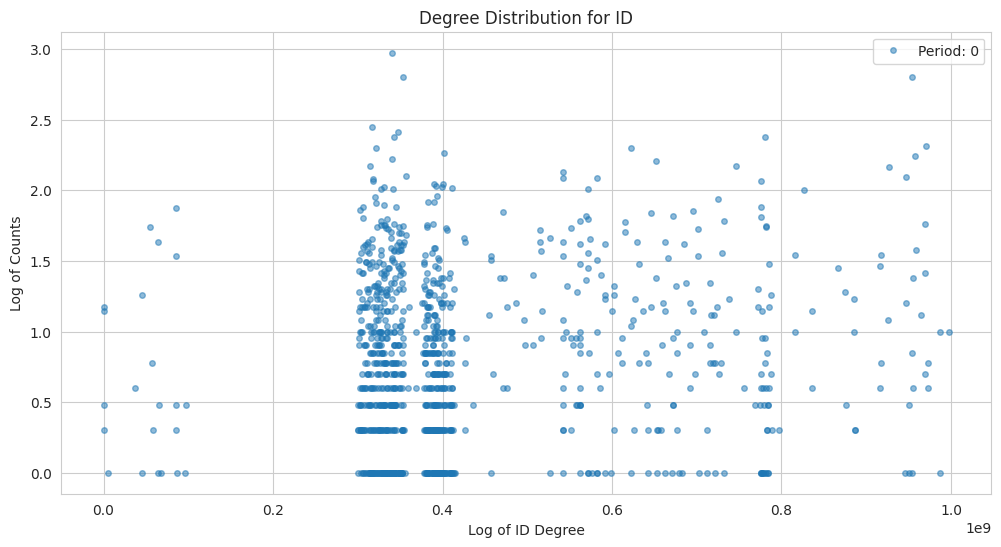

KeyError: 'log_ID_degree'

<Figure size 1200x600 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_distribution(df, time_window_col='time_window', degree_col='ID', log_count_col='log_'+degree_col+'_degree', sample_size=1000):
    """
    Plots the degree distribution over different time windows.

    Args:
    - df (DataFrame): The dataframe containing the degree distribution data.
    - time_window_col (str): The column name for the time window.
    - degree_col (str): The column name for the degree.
    - log_count_col (str): The column name for the log of counts.
    - sample_size (int): Number of data points to sample for each period for faster plotting.
    """
    plt.figure(figsize=(12, 6))
    for period, group_df in df.groupby(time_window_col):
        sample_df = group_df.sample(min(sample_size, len(group_df)), random_state=42)  # Sampling for faster plotting
        plt.plot(sample_df[degree_col], sample_df[log_count_col], marker='o', linestyle='', alpha=0.5, markersize=4, label=f'Period: {period}')
    plt.xlabel(f'Log of {degree_col} Degree')
    plt.ylabel('Log of Counts')
    plt.title(f'Degree Distribution for {degree_col}')
    plt.legend()
    plt.show()

# Plotting the ID degree distribution
plot_degree_distribution(id_degree_dist, degree_col='ID')

# Plotting the VAT degree distribution
plot_degree_distribution(vat_degree_dist, degree_col='VAT')


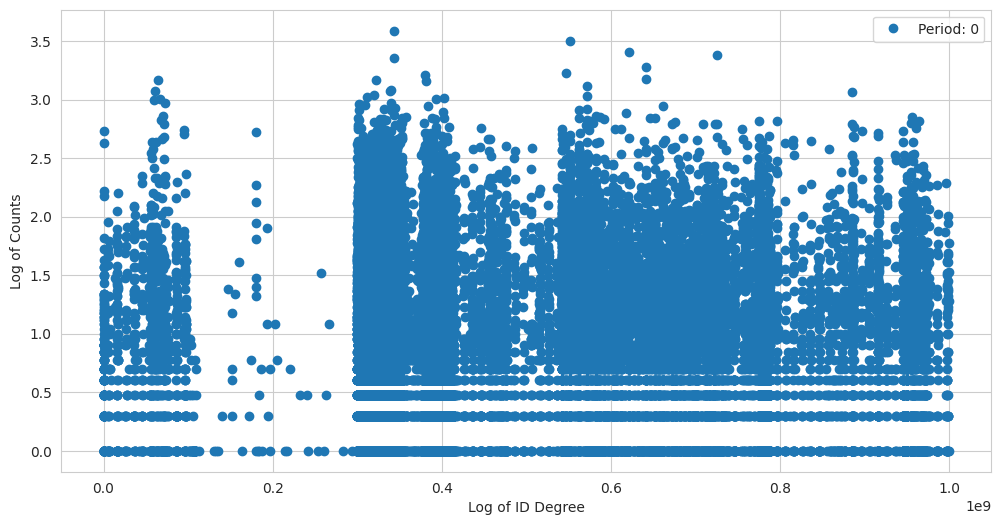

In [35]:
# Save the degree distribution dataframes for future use
id_degree_dist.to_csv('./../../data/analysis/id_degree_distribution.csv', index=False)
vat_degree_dist.to_csv('./../../data/analysis/vat_degree_distribution.csv', index=False)

# Simple visualization of the degree distributions
degree_col = 'ID'
def plot_degree_distribution(df, time_window_col='time_window', degree_col='ID', log_count_col='log_'+degree_col+'_degree'):
    plt.figure(figsize=(12, 6))
    for period, group_df in df.groupby(time_window_col):
        plt.plot(group_df[degree_col], group_df[log_count_col], marker='o', linestyle='', label=f'Period: {period}')
    plt.xlabel(f'Log of {degree_col} Degree')
    plt.ylabel('Log of Counts')
    plt.legend()
    plt.show()

# Plotting the degree distributions
plot_degree_distribution(id_degree_dist, degree_col = 'ID')
# plot_degree_distribution(vat_degree_dist.loc[vat_degree_dist.counts > 1].sample(50000), degree_col = 'VAT') # len(id_degree_dist) = 50k


In [ ]:
vat_degree_dist.head()

,time_window,VAT,counts,log_counts
0,0,AT0000049,1,0.0
1,0,AT0000078,1,0.0
2,0,AT0000124,1,0.0
3,0,AT0000129,1,0.0
4,0,AT0000162,1,0.0


In [ ]:
id_degree_dist.shape

(51945, 4)